In [ ]:
!pip install optuna

In [ ]:
!pip install shap

In [ ]:
import pandas as pd
import numpy as np

import copy
import pickle
from datetime import datetime

import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import median_absolute_error as MAPE
from sklearn.metrics import r2_score  as R2
from xgboost import plot_importance
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

from sklearn.metrics import r2_score

# Parameter tunning
from sklearn.model_selection import KFold

import seaborn as sns
import matplotlib.pyplot as plt 

import optuna

import shap

from google.colab import drive
%matplotlib inline

Version: 1

Data description:
- 1127 postcodes
- Google POI + EPC statistics + Property Data

Goal: Rents

In [ ]:
# Execute this cell paste the Key, and press the key ENTER...
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
Data = pd.read_csv('/content/drive/My Drive/UKBenEstate/datasetV6.csv') 


In [ ]:
list(Data.columns)

['Unnamed: 0',
 'postcode',
 'synagogue_rating_mean_1500',
 'synagogue_rating_std_1500',
 'synagogue_count_1500',
 'synagogue_rating_mean_1000',
 'synagogue_rating_std_1000',
 'synagogue_count_1000',
 'synagogue_rating_mean_500',
 'synagogue_rating_std_500',
 'synagogue_count_500',
 'synagogue_min',
 'shopping_mall_rating_mean_1500',
 'shopping_mall_rating_std_1500',
 'shopping_mall_count_1500',
 'shopping_mall_rating_mean_1000',
 'shopping_mall_rating_std_1000',
 'shopping_mall_count_1000',
 'shopping_mall_rating_mean_500',
 'shopping_mall_rating_std_500',
 'shopping_mall_count_500',
 'shopping_mall_min',
 'secondary_rating_mean_1500',
 'secondary_rating_std_1500',
 'secondary_count_1500',
 'secondary_rating_mean_1000',
 'secondary_rating_std_1000',
 'secondary_count_1000',
 'secondary_rating_mean_500',
 'secondary_rating_std_500',
 'secondary_count_500',
 'secondary_min',
 'school_rating_mean_1500',
 'school_rating_std_1500',
 'school_count_1500',
 'school_rating_mean_1000',
 'school

### Crime

In [ ]:
Data['crime_total']=Data['PublicOrder']+Data['Burglary']+Data['Robbery']+Data['PossessionOfWeapons']+Data['BicycleTheft']+Data['AntiSocialBehaviour']+Data['Violence']+Data['Theft']+Data['Shoplifting']+Data['OtherCrime']+Data['Drugs']+Data['OtherTheft']+Data['VehicleCrime']+Data['CriminalDamage']

In [ ]:
Data['PublicOrder']=Data['PublicOrder']/Data['crime_total']

In [ ]:
Data['Burglary'] = Data['Burglary']/Data['crime_total']
Data['Robbery'] = Data['Robbery']/Data['crime_total']
Data['PossessionOfWeapons'] = Data['PossessionOfWeapons']/Data['crime_total']
Data['BicycleTheft'] = Data['BicycleTheft']/Data['crime_total']
Data['AntiSocialBehaviour'] = Data['AntiSocialBehaviour']/Data['crime_total']
Data['Violence'] = Data['Violence']/Data['crime_total']
Data['Theft'] = Data['Theft']/Data['crime_total']
Data['Shoplifting'] = Data['Shoplifting']/Data['crime_total']
Data['OtherCrime'] = Data['OtherCrime']/Data['crime_total']
Data['Drugs'] = Data['Drugs']/Data['crime_total']
Data['OtherTheft'] = Data['OtherTheft']/Data['crime_total']
Data['VehicleCrime'] = Data['VehicleCrime']/Data['crime_total']
Data['CriminalDamage'] = Data['CriminalDamage']/Data['crime_total']

Data['crime_Type_A'] = Data['Robbery']+Data['Drugs']+Data['PossessionOfWeapons']+Data['Burglary']+Data['OtherCrime']
Data['crime_Type_B'] = Data['OtherTheft'] + Data['Shoplifting'] + Data['Theft'] + Data['BicycleTheft']
Data['crime_Type_C'] = Data['CriminalDamage']+ Data['Violence'] + Data['AntiSocialBehaviour']
Data['crime_Type_D'] = Data['VehicleCrime']

In [ ]:
dropList=['Burglary',
 'Robbery',
 'PossessionOfWeapons',
 'BicycleTheft',
 'AntiSocialBehaviour',
 'Violence',
 'Theft',
 'Shoplifting',
 'OtherCrime',
 'Drugs',
 'OtherTheft',
 'VehicleCrime',
 'CriminalDamage',]
Data.drop(dropList, axis = 1, inplace = True)

### Age 

error: age55_59 age65-69

In [ ]:
Data['TotalModPop'] = Data['age20_24']+Data['age25_29']+Data['age30_34']+Data['age35_39']+Data['age40_44']+Data['age45_49']+Data['age45_49']+Data['age50_54']+Data['age60_64']
Data['age20_29'] = Data['age20_24']+Data['age25_29']
Data['age30_64'] = Data['age30_34']+Data['age35_39']+Data['age40_44']+Data['age45_49']+Data['age50_54']+Data['age60_64']
Data['age65_'] = Data['age70_74']+Data['age75_79']+Data['age80_84']+Data['age85_89']

In [ ]:
dropList=['age20_24',
 'age25_29',
 'age30_34',
 'age35_39',
 'age40_44',
 'age45_49',
 'age50_54',
 'age60_64',
 'age70_74',
 'age75_79',
 'age80_84',
 'age85_89']
Data.drop(dropList, axis = 1, inplace = True)

In [ ]:
Data['commute_method_public'] = Data['commute_method_train'] + Data['commute_method_bus'] + Data['commute_method_underground_light_rail']
Data['commute_method_private'] = Data['commute_method_motorcycle'] + Data['commute_method_taxi'] + Data['commute_method_car_driver'] + Data['commute_method_car_passenger']
Data['commute_method_open'] = Data['commute_method_foot']+Data['commute_method_bicycle']

In [ ]:
dropList=['commute_method_foot',
 'commute_method_bicycle',
 'commute_method_other',
 'commute_method_motorcycle',
 'commute_method_taxi',
 'commute_method_train',
 'commute_method_bus',
 'commute_method_underground_light_rail',
 'commute_method_car_driver',
 'commute_method_at_home',
 'commute_method_car_passenger',
]
Data.drop(dropList, axis = 1, inplace = True)

In [ ]:
#Data['sold_70pc_disp']=-(Data['sold_70pc_rangeMIN']-Data['sold_70pc_rangeMAX'])/Data['sold_average']
#Data['sold_80pc_disp']=-(Data['sold_80pc_rangeMIN']-Data['sold_80pc_rangeMAX'])/Data['sold_average']
#Data['sold_90pc_disp']=-(Data['sold_90pc_rangeMIN']-Data['sold_90pc_rangeMAX'])/Data['sold_average']
#Data['sold_100pc_disp']=-(Data['sold_100pc_rangeMIN']-Data['sold_100pc_rangeMAX'])/Data['sold_average']

In [ ]:
#Data['sold_sqf_70pc_disp'] =-(Data['sold_sqf_70pc_rangeMIN']-Data['sold_sqf_70pc_rangeMAX'])/Data['sold_sqf_average']
#Data['sold_sqf_80pc_disp'] =-(Data['sold_sqf_80pc_rangeMIN']-Data['sold_sqf_80pc_rangeMAX'])/Data['sold_sqf_average']
#Data['sold_sqf_90pc_disp'] =-(Data['sold_sqf_90pc_rangeMIN']-Data['sold_sqf_90pc_rangeMAX'])/Data['sold_sqf_average']
#Data['sold_sqf_100pc_disp'] =-(Data['sold_sqf_100pc_rangeMIN']-Data['sold_sqf_100pc_rangeMAX'])/Data['sold_sqf_average']

In [ ]:
#Data['rents_70pc_disp'] = -(Data['rents_70pc_rangeMIN']-Data['rents_70pc_rangeMAX'])/Data['rents_average']
#Data['rents_80pc_disp'] =-(Data['rents_80pc_rangeMIN']-Data['rents_80pc_rangeMAX'])/Data['rents_average']
#Data['rents_90pc_disp'] =-(Data['rents_90pc_rangeMIN']-Data['rents_90pc_rangeMAX'])/Data['rents_average']
#Data['rents_100pc_disp'] =-(Data['rents_100pc_rangeMIN']-Data['rents_100pc_rangeMAX'])/Data['rents_average']

In [ ]:
dropList=[ 'dyn_sold_points_analysed',
 'dyn_sold_70pc_rangeMIN',
 'dyn_sold_70pc_rangeMAX',
 'dyn_sold_80pc_rangeMIN',
 'dyn_sold_80pc_rangeMAX',
 'dyn_sold_90pc_rangeMIN',
 'dyn_sold_90pc_rangeMAX',
 'dyn_sold_sqf_points_analysed',
 'dyn_sold_sqf_70pc_rangeMIN',
 'dyn_sold_sqf_70pc_rangeMAX',
 'dyn_sold_sqf_80pc_rangeMIN',
 'dyn_sold_sqf_80pc_rangeMAX',
 'dyn_sold_sqf_90pc_rangeMIN',
 'dyn_sold_sqf_90pc_rangeMAX',
 'dyn_rents_points_analysed',
 'dyn_rents_70pc_rangeMIN',
 'dyn_rents_70pc_rangeMAX',
 'dyn_rents_80pc_rangeMIN',
 'dyn_rents_80pc_rangeMAX',
 'dyn_rents_90pc_rangeMIN',
 'dyn_rents_90pc_rangeMAX',]
Data.drop(dropList, axis = 1, inplace = True)

In [ ]:
### POI 


In [ ]:
Data['HousePerPopulation']=Data['Households']/Data['Population']

In [ ]:
#Data['construction_before_1950']=(Data['construction_before_1900'] + Data['construction_1900_1929'] + Data['construction_1930_1949']) 
#Data['construction_1950_1975']=(Data['construction_1950_1966']+Data['construction_1967_1975']+ Data['construction_1976_1982'])
#Data['construction_1983_1990']=(Data['construction_1983_1990']+Data['construction_1991_1995'])
#Data['construction_1996_2006']=(Data['construction_1996_2002']+Data['construction_2003_2006'])
#Data['construction_2007_onwards']=(Data['construction_2007_2011']+Data['construction_2012_onwards'])

In [ ]:
dropList=['construction_before_1900',
 'construction_1900_1929',
 'construction_1930_1949',
 'construction_1950_1966',
 'construction_1967_1975',
 'construction_1976_1982',
 'construction_1983_1990',
 'construction_1991_1995',
 'construction_1996_2002',
 'construction_2003_2006',
 'construction_2007_2011',
 'construction_2012_onwards']
#Data.drop(dropList, axis = 1, inplace = True)

No handles with labels found to put in legend.


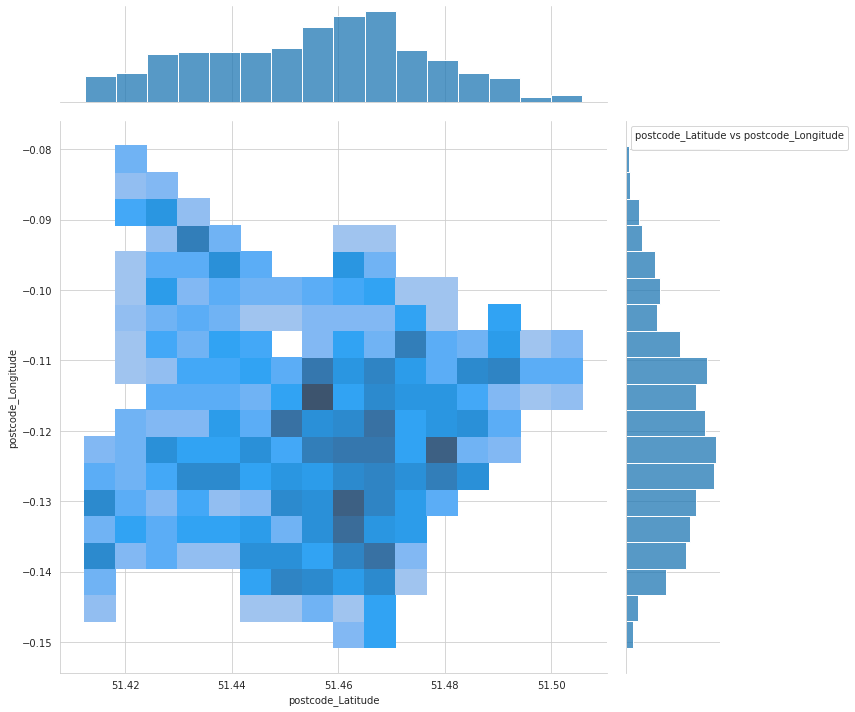

In [ ]:
sns.set_style('whitegrid')
sns.jointplot(x ='postcode_Latitude', y ='postcode_Longitude', data = Data, kind ='hist',height=10)
plt.legend(title='postcode_Latitude vs postcode_Longitude')

No handles with labels found to put in legend.


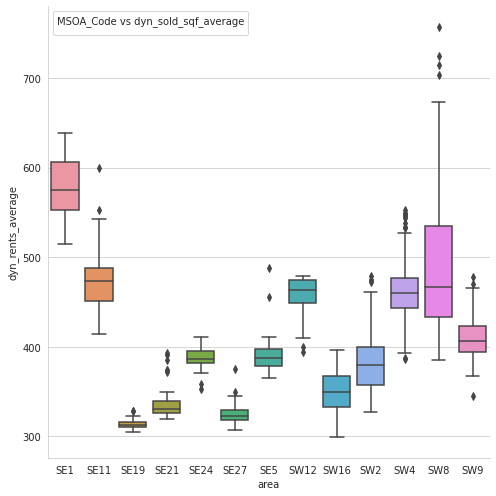

In [ ]:
sns.catplot(x="area", y='dyn_rents_average',  kind="box", data=Data,height=7)
plt.legend(title='MSOA_Code vs dyn_sold_sqf_average')

No handles with labels found to put in legend.


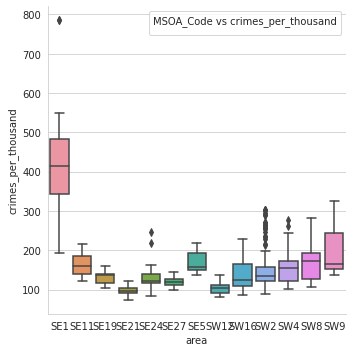

In [ ]:
sns.catplot(x="area", y="crimes_per_thousand",  kind="box", data=Data)
plt.legend(title='MSOA_Code vs crimes_per_thousand')

Removing inrelevant attributes

In [ ]:
dropList=['Unnamed: 0','postcode','count',
         'postcode_Latitude','postcode_Longitude','MSOA_Code','LSOA_Code','area'
          ]
Data.drop(dropList, axis = 1, inplace = True)

In [ ]:
dropList=['dyn_sold_average',
 'dyn_sold_100pc_rangeMIN',
 'dyn_sold_100pc_rangeMAX',
 'dyn_sold_sqf_100pc_rangeMIN',
 'dyn_sold_sqf_100pc_rangeMAX',
 'dyn_sold_sqf_average',
 'dyn_rents_100pc_rangeMIN',
 'dyn_rents_100pc_rangeMAX',
         ]
Data.drop(dropList, axis = 1, inplace = True)

Adding the rental price by sq

No handles with labels found to put in legend.


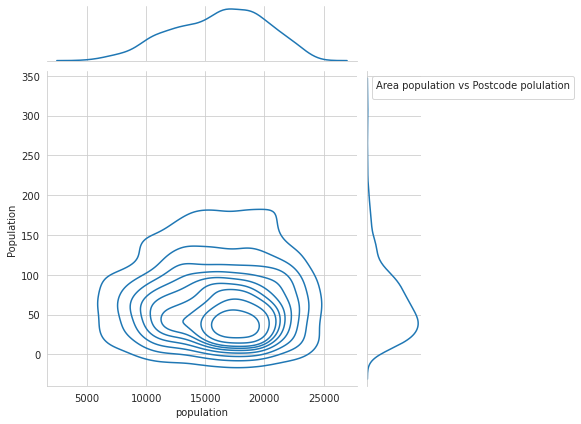

In [ ]:
sns.set_style('whitegrid')
sns.jointplot(x ='population', y ='Population', data = Data, kind ='kde')
plt.legend(title='Area population vs Postcode polulation')

### Rental price statistics

In [ ]:
Data['dyn_rents_average'].describe()

count    1127.000000
mean      409.968944
std        67.114718
min       299.000000
25%       358.500000
50%       401.000000
75%       453.000000
max       757.000000
Name: dyn_rents_average, dtype: float64

No handles with labels found to put in legend.


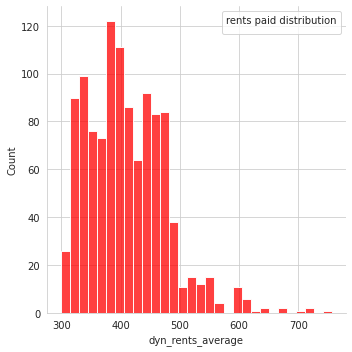

In [ ]:
sns.set_style('whitegrid')
sns.displot(Data[ 'dyn_rents_average'], kde = False, color ='red', bins = 30)
plt.legend(title='rents paid distribution')

No handles with labels found to put in legend.


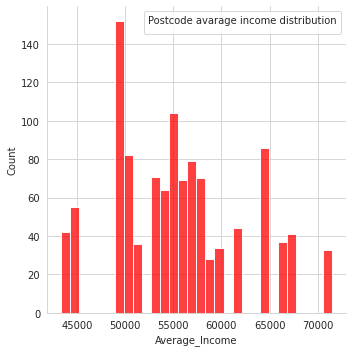

In [ ]:
sns.set_style('whitegrid')
sns.displot(Data['Average_Income'], kde = False, color ='red', bins = 30)
plt.legend(title='Postcode avarage income distribution')

No handles with labels found to put in legend.


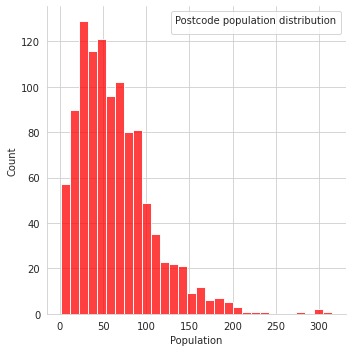

In [ ]:
sns.set_style('whitegrid')
sns.displot(Data['Population'], kde = False, color ='red', bins = 30)
plt.legend(title='Postcode population distribution')

No handles with labels found to put in legend.


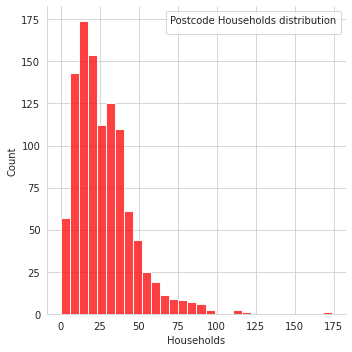

In [ ]:
sns.set_style('whitegrid')
sns.displot(Data['Households'], kde = False, color ='red', bins = 30)
plt.legend(title='Postcode Households distribution')

No handles with labels found to put in legend.


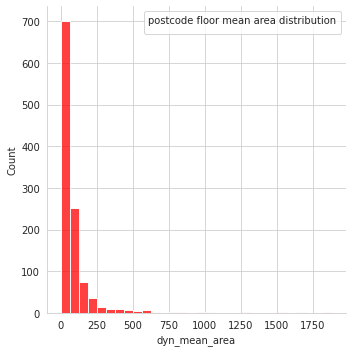

In [ ]:
sns.set_style('whitegrid')
sns.displot(Data['dyn_mean_area'], kde = False, color ='red', bins = 30)
plt.legend(title='postcode floor mean area distribution')

### Categorical attribute binarization

In [ ]:

catData = ['dyn_ptal', 'dyn_flood_risk','crime_rating']
for att in catData:
    unique_classes = Data[att].unique()
    one_hot = pd.get_dummies(unique_classes, prefix=att,dummy_na=True, columns = [att])
    one_hot[att] = unique_classes
    Data = Data.merge(one_hot, on = [att], how='left')
    Data = Data.drop(columns = [att])

In [ ]:
list(Data.columns)

['synagogue_rating_mean_1500',
 'synagogue_rating_std_1500',
 'synagogue_count_1500',
 'synagogue_rating_mean_1000',
 'synagogue_rating_std_1000',
 'synagogue_count_1000',
 'synagogue_rating_mean_500',
 'synagogue_rating_std_500',
 'synagogue_count_500',
 'synagogue_min',
 'shopping_mall_rating_mean_1500',
 'shopping_mall_rating_std_1500',
 'shopping_mall_count_1500',
 'shopping_mall_rating_mean_1000',
 'shopping_mall_rating_std_1000',
 'shopping_mall_count_1000',
 'shopping_mall_rating_mean_500',
 'shopping_mall_rating_std_500',
 'shopping_mall_count_500',
 'shopping_mall_min',
 'secondary_rating_mean_1500',
 'secondary_rating_std_1500',
 'secondary_count_1500',
 'secondary_rating_mean_1000',
 'secondary_rating_std_1000',
 'secondary_count_1000',
 'secondary_rating_mean_500',
 'secondary_rating_std_500',
 'secondary_count_500',
 'secondary_min',
 'school_rating_mean_1500',
 'school_rating_std_1500',
 'school_count_1500',
 'school_rating_mean_1000',
 'school_rating_std_1000',
 'school_

### Define rental price as the model goal 

In [ ]:
Data['price'] = Data['dyn_rents_average']
Data.drop(['dyn_rents_average'], axis = 1, inplace = True)

In [ ]:
# Split data: X,y
X, y = Data.iloc[:, :-1], Data.iloc[:, -1]

### Model tunning


In [ ]:
def objective(trial, X, y, kf):
    n_estimators = trial.suggest_int('n_estimators', 206, 512)
    learning_rate =trial.suggest_uniform('learning_rate', 0, 0.1) 
    #max_depth = trial.suggest_int('max_depth', 3, 10)
    min_split_loss = trial.suggest_uniform('min_split_loss', 0, 2.5)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    reg_lambda = trial.suggest_uniform('reg_lambda', 0, 10)
    reg_alpha = trial.suggest_uniform('reg_alpha', 0, 10)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1)
    subsample = trial.suggest_uniform('subsample', 0.5, 1)
    eta = trial.suggest_uniform('eta', 0, 1)
    
    model = xg.XGBRegressor(n_estimators=n_estimators,
                          #max_depth=max_depth,
                          learning_rate=learning_rate,
                          min_split_loss=min_split_loss,
                          min_child_weight=min_child_weight,
                          reg_lambda=reg_lambda,
                          reg_alpha=reg_alpha,
                          colsample_bytree=colsample_bytree,
                          subsample=subsample,
                          eta=eta,
                          objective='reg:squarederror', 
                          booster='gbtree',
                          seed=42,
                          n_jobs=3)
    
    
    test_score = []
    
    step = 0
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        test_score.append(MAE(y_test, y_pred)/715.212067*100)
        #test_score.append(R2(y_test, y_pred))
        
        trial.report(np.mean(test_score), step)
        
        if trial.should_prune():
            raise optuna.TrialPruned()
            
        step+=1

    return np.mean(test_score)



kf = KFold(n_splits=4, shuffle=True, random_state=42)

study = optuna.create_study(direction='minimize',
                            pruner=optuna.pruners.SuccessiveHalvingPruner())

study.optimize(lambda trial: objective(trial, X, y, kf), timeout=30*60, n_jobs=1)

study.best_params 

[I 2022-03-29 01:11:39,239] A new study created in memory with name: no-name-cad61d00-a71a-42d2-a3b7-346cbc36a055
[I 2022-03-29 01:11:49,753] Trial 0 finished with value: 1.5417228686636397 and parameters: {'n_estimators': 473, 'learning_rate': 0.019858676882215067, 'min_split_loss': 2.279779368675639, 'min_child_weight': 3, 'reg_lambda': 7.127992267778408, 'reg_alpha': 1.1317218404690887, 'colsample_bytree': 0.5967413236992296, 'subsample': 0.7539588421668016, 'eta': 0.318433324117226}. Best is trial 0 with value: 1.5417228686636397.
[I 2022-03-29 01:11:58,743] Trial 1 finished with value: 1.429997159546231 and parameters: {'n_estimators': 370, 'learning_rate': 0.0937874510066035, 'min_split_loss': 1.3424067374405872, 'min_child_weight': 1, 'reg_lambda': 9.072150514612197, 'reg_alpha': 7.251369890224674, 'colsample_bytree': 0.593152358611001, 'subsample': 0.7843852497802684, 'eta': 0.6710998529947798}. Best is trial 1 with value: 1.429997159546231.
[I 2022-03-29 01:12:02,679] Trial 2 

{'colsample_bytree': 0.8869513661996383,
 'eta': 0.24504791322780245,
 'learning_rate': 0.05525380137897206,
 'min_child_weight': 4,
 'min_split_loss': 0.5026175052996026,
 'n_estimators': 488,
 'reg_alpha': 9.082276078989404,
 'reg_lambda': 0.0007994337272663188,
 'subsample': 0.748394096471245}

In [ ]:
# Splitting Train/Test
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                      test_size = 0.2)

### Model

In [ ]:
model = XGBRegressor(objective='reg:squarederror', 
                     n_estimators=  488,
                     learning_rate= 0.05525380137897206,
                     min_split_loss= 0.5026175052996026,
                     min_child_weight= 4,
                     reg_lambda= 0.0007994337272663188,
                     reg_alpha= 9.082276078989404,
                     colsample_bytree= 0.8869513661996383,
                     subsample=   0.748394096471245,
                     eta= 0.24504791322780245)

xgb_r = model.fit(train_X, train_y)

pred_train = model.predict(train_X)
pred_test = model.predict(test_X)

# MAE Computation
mae =MAE(train_y, pred_train)
print("Train MAE : % f --- %f" %(mae,mae/409.968944*100),"%")
# MAE Computation
mae =MAE(test_y, pred_test)
print("Test MAE : % f --- %f" %(mae,mae/409.968944*100),"%")

# MAE Computation
mape =MAPE(train_y, pred_train)
print("Train MAPE : % f --- %f" %(mape,mape/409.968944*100),"%")
# MAE Computation
mape =MAPE(test_y, pred_test)
print("Test MAPE : % f --- %f" %(mape,mape/409.968944*100),"%")

# MAE Computation
r2 =R2(train_y, pred_train)
print("Train R2 : % f" %(r2))
# MAE Computation
r2 =R2(test_y, pred_test)
print("Test R2 : % f" %(r2))

Train MAE :  2.798894 --- 0.682709 %
Test MAE :  9.621230 --- 2.346819 %
Train MAPE :  2.364685 --- 0.576796 %
Test MAPE :  7.469833 --- 1.822049 %
Train R2 :  0.997107
Test R2 :  0.965415


No handles with labels found to put in legend.


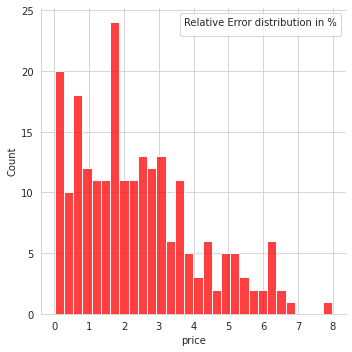

In [ ]:
sns.set_style('whitegrid')
sns.displot( abs(test_y-pred_test)/test_y*100, kde = False, color ='red', bins = 30)
plt.legend(title='Relative Error distribution in %')

Cross validation

In [ ]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
# MAE Computation
print("CV MAE : £" ,scores.mean(), scores.mean()/409.968944*100," % --- std £",scores.std())

CV MAE : £ 9.29957054490235 2.268359757733832  % --- std £ 0.7142599550453957


In [99]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate model
scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)

# R2 Computation
print("CV R2 :" ,scores.mean(), " std:",scores.std())

CV R2 : 0.9624636849509701  std: 0.005759984027051642


In [ ]:
import sklearn.metrics

In [ ]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

### Plot feature importance

https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7

- The Gain implies the relative contribution of the corresponding feature to the model calculated by taking each feature’s contribution for each tree in the model. 
- The Coverage metric means the relative number of observations related to this feature.
- The Weight  is the percentage representing the relative number of times a particular feature occurs in the trees of the model
- ‘Gain’ is the improvement in accuracy brought by a feature to the branches it is on. 
- ‘Coverage’ measures the relative quantity of observations concerned by a feature.”


#### Ranking by gain (uses the loss)

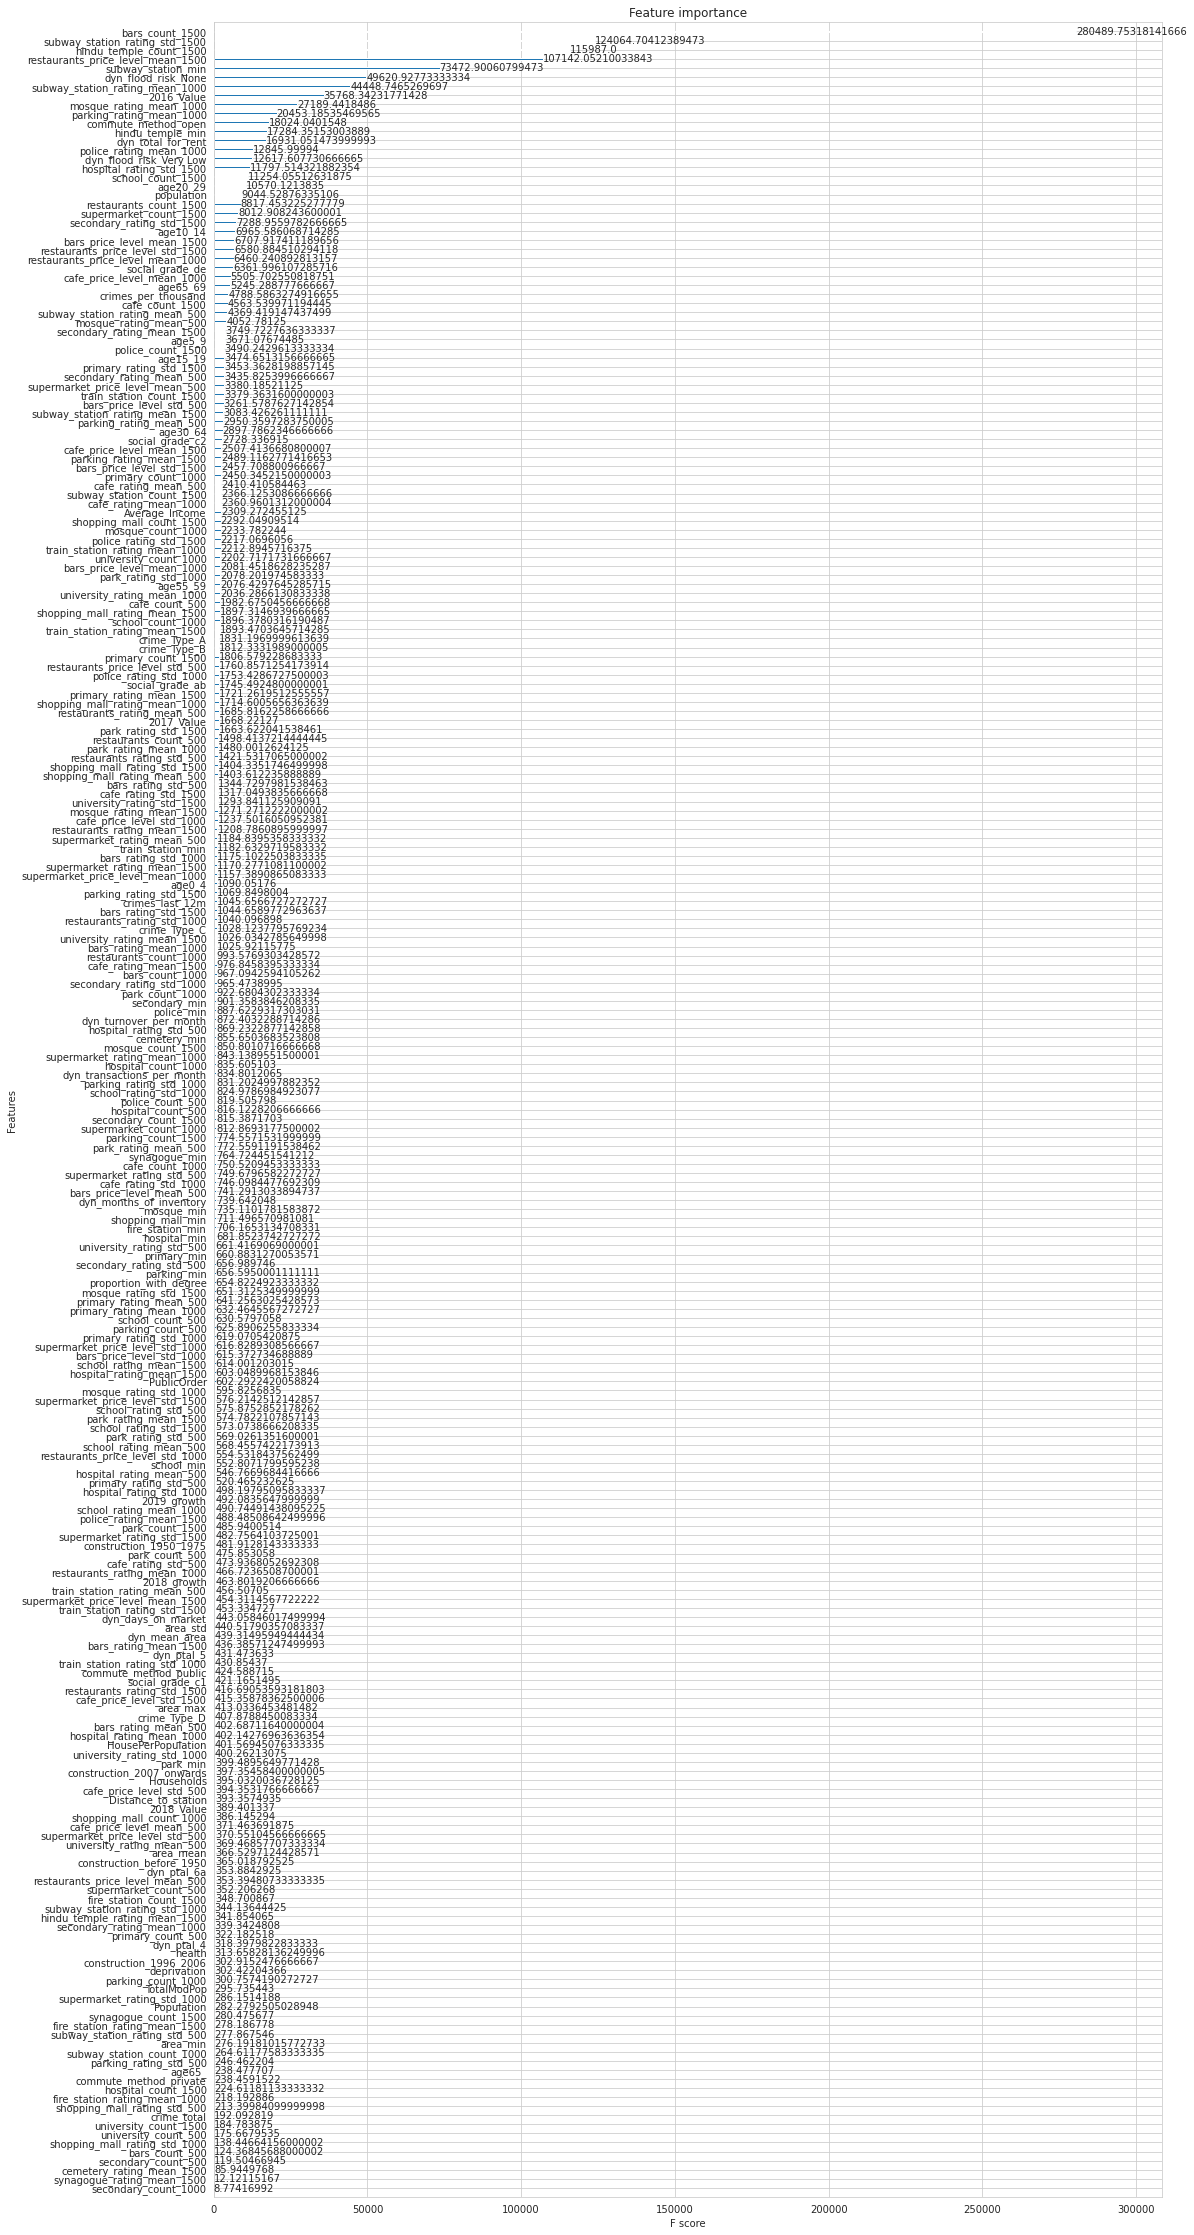

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(17,40))

xg.plot_importance(xgb_r, ax,importance_type='gain')

#### Ranking by cover

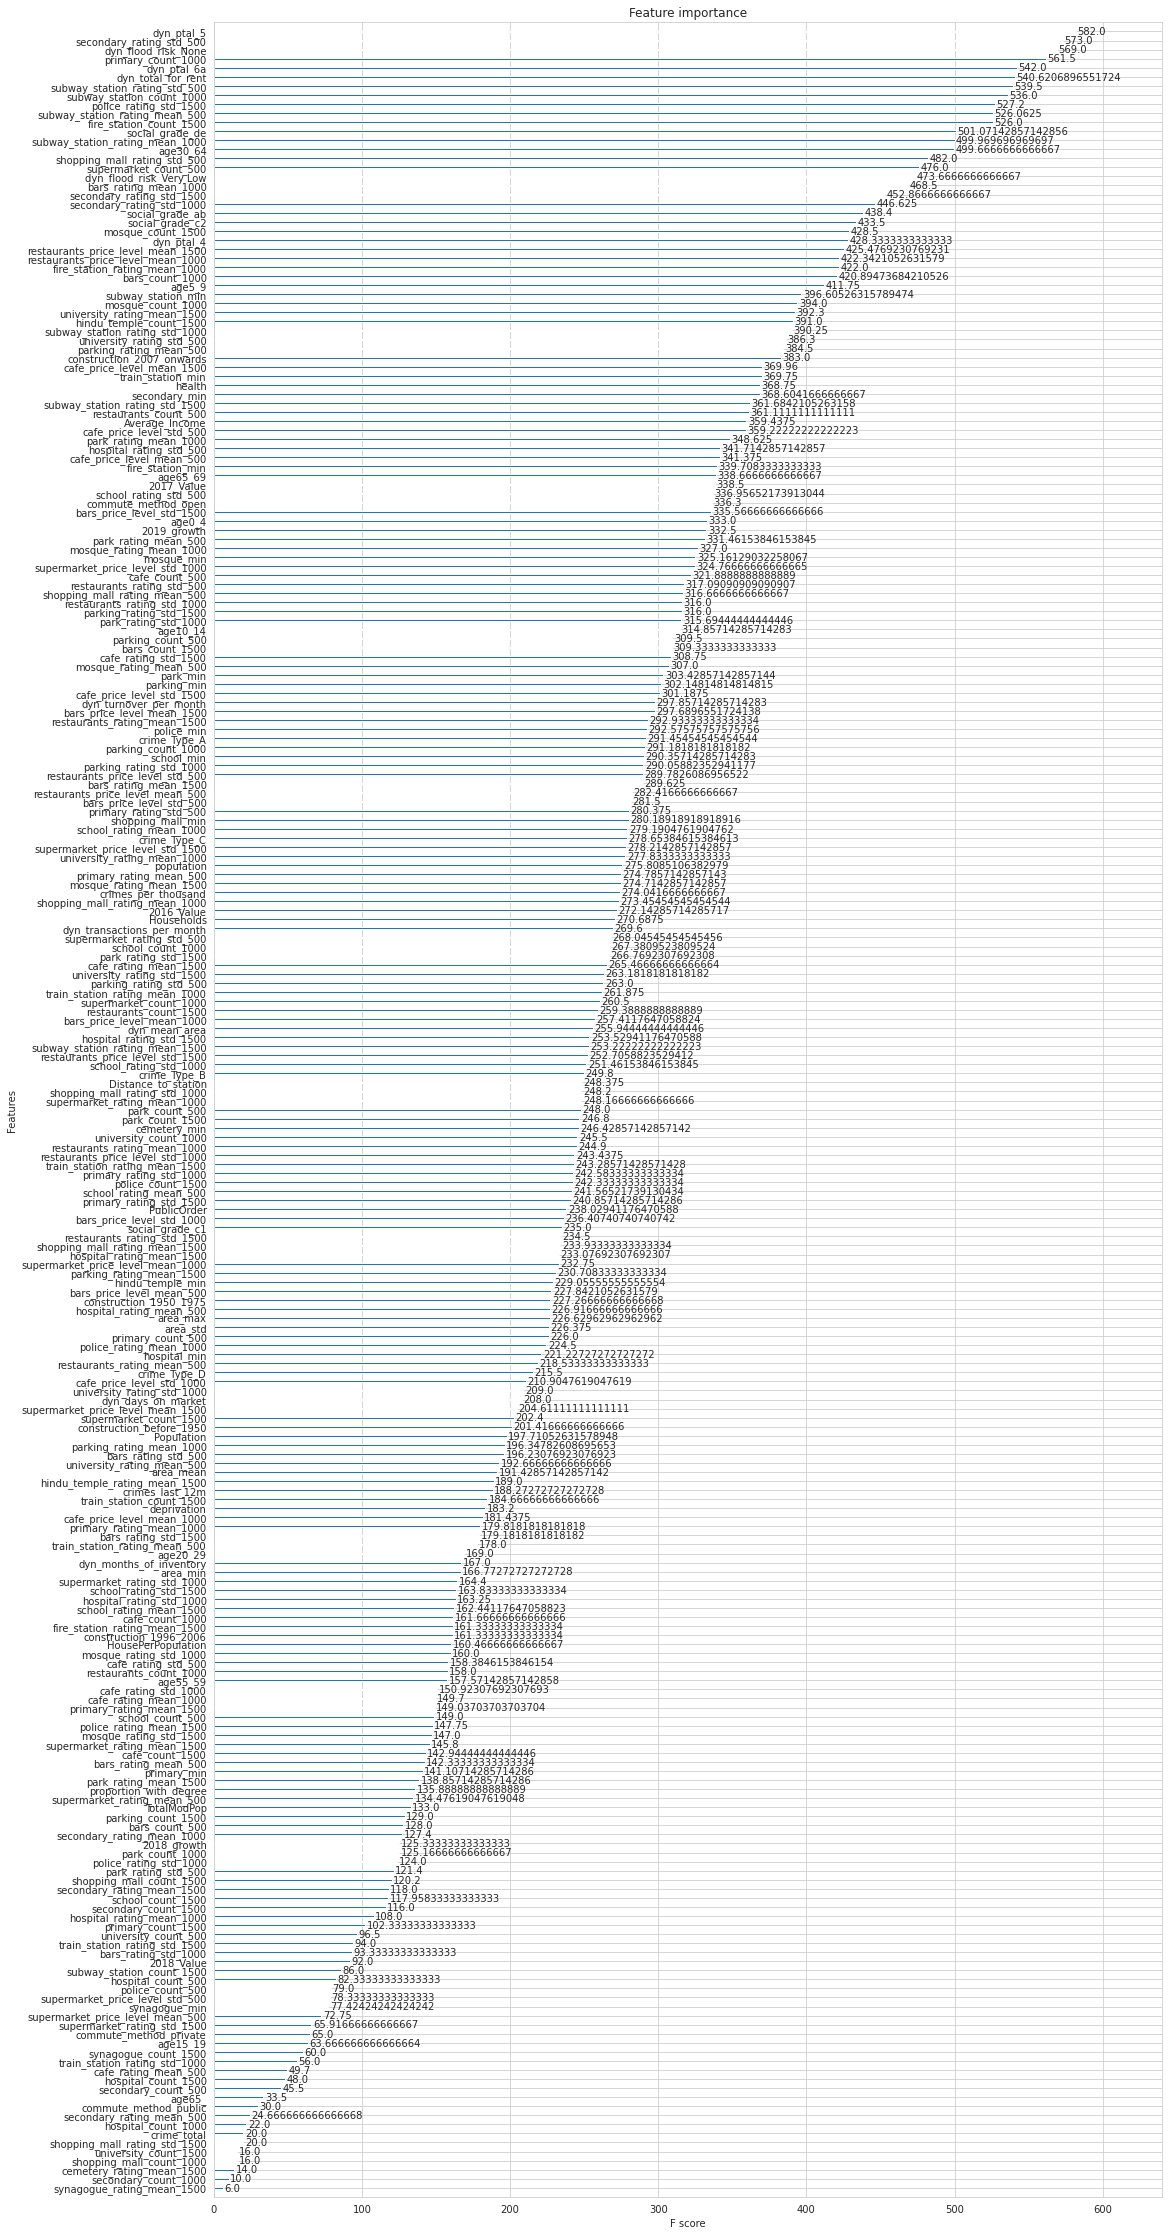

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(17,40))

xg.plot_importance(xgb_r, ax,importance_type='cover')

#### Ranking by total gain

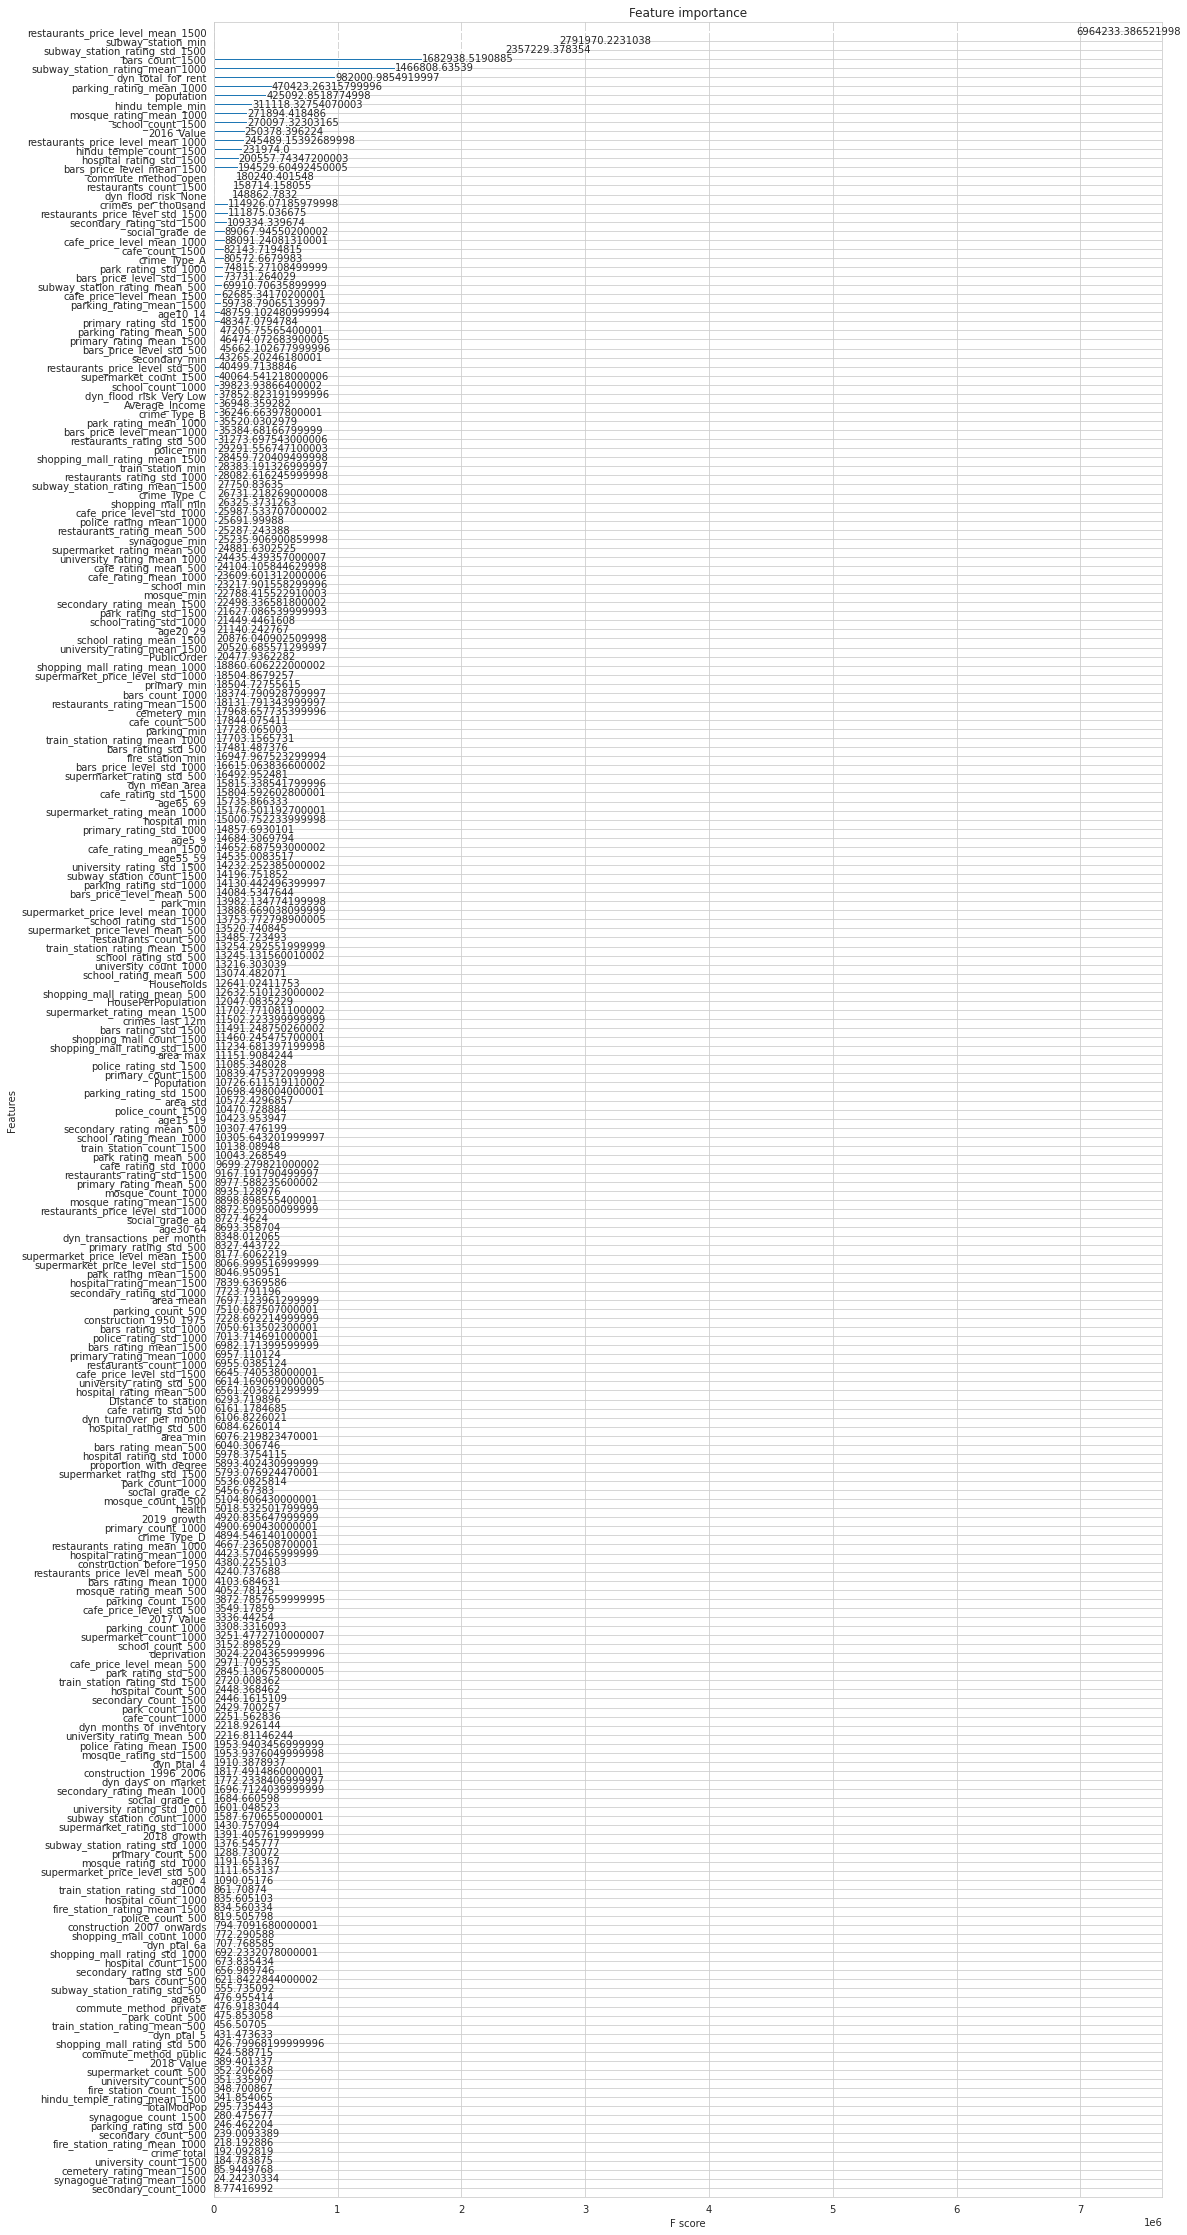

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(17,40))

xg.plot_importance(xgb_r, ax,importance_type='total_gain')

#### Ranking by total cover (uses the total loss)

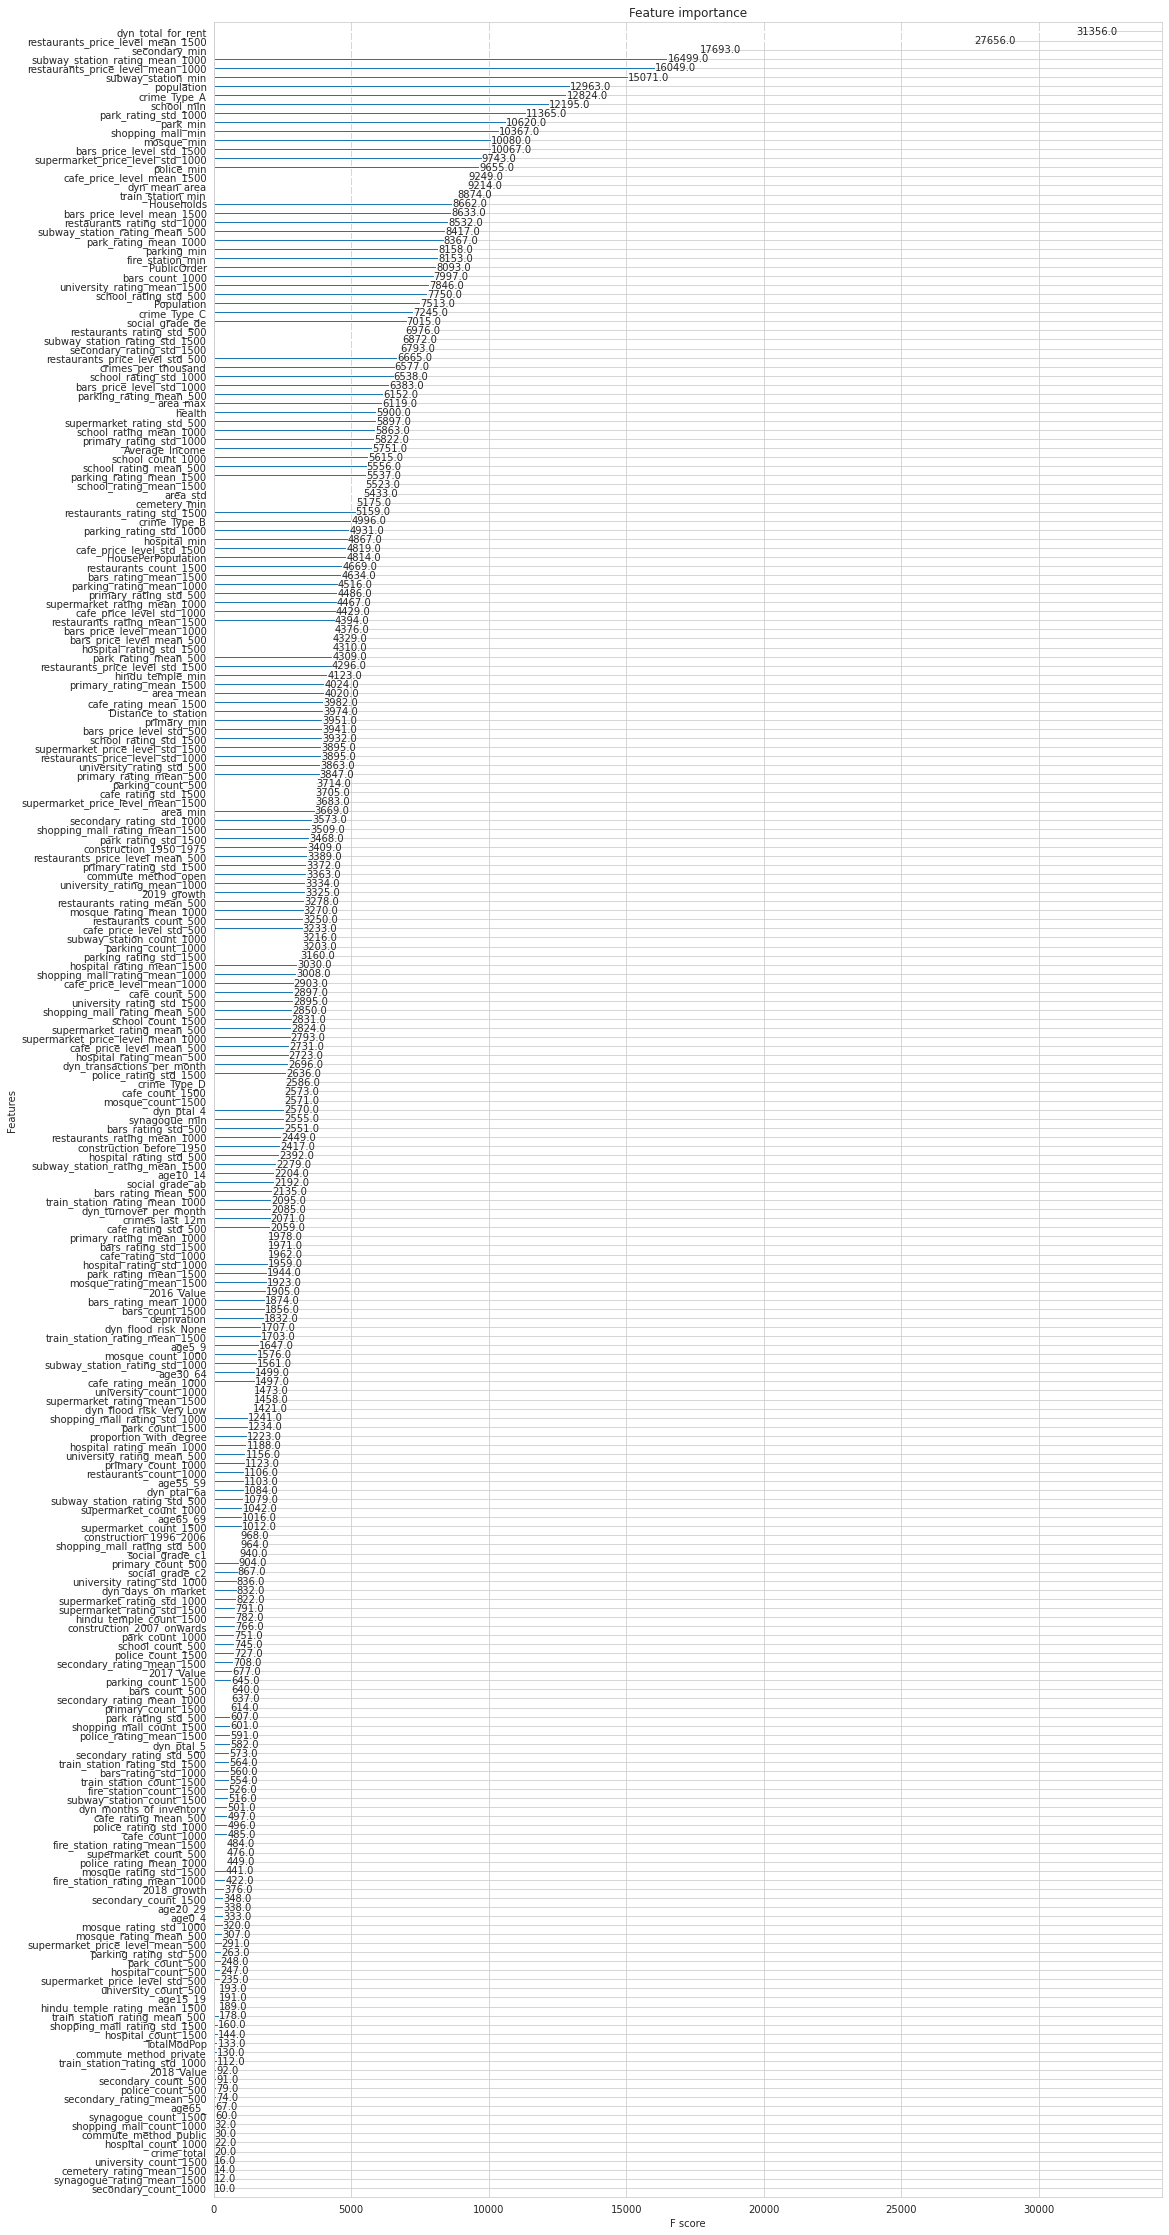

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(17,40))

xg.plot_importance(xgb_r, ax,importance_type='total_cover')

#### Ranking by weight

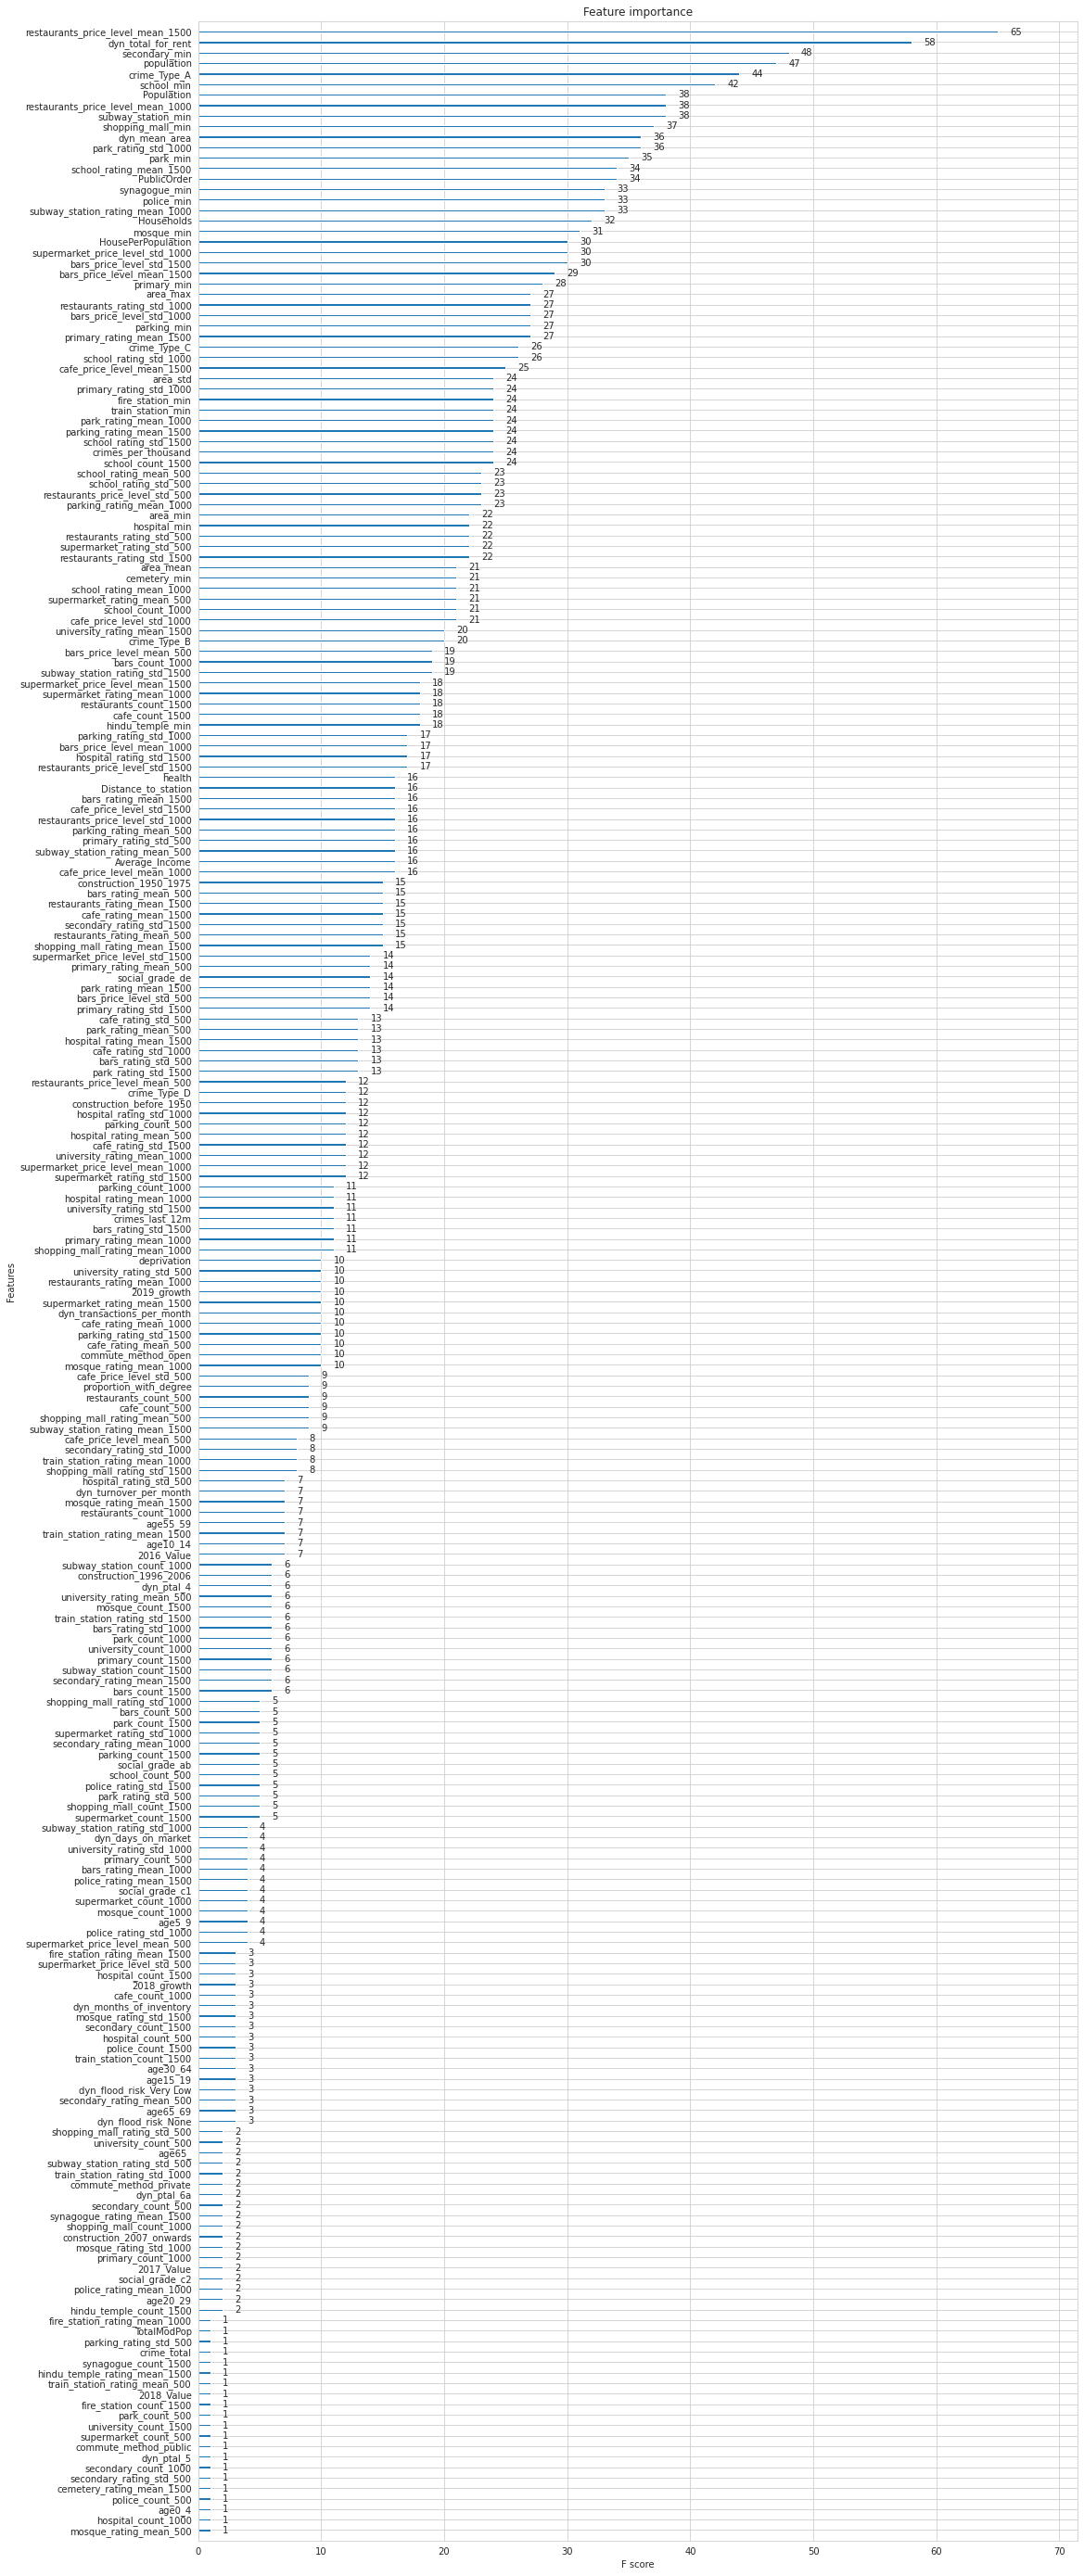

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(17,50))

xg.plot_importance(xgb_r, ax,importance_type='weight')

The following kwargs were not used by contour: 'row'
No handles with labels found to put in legend.


Text(0.5, 32.99999999999995, 'real price')

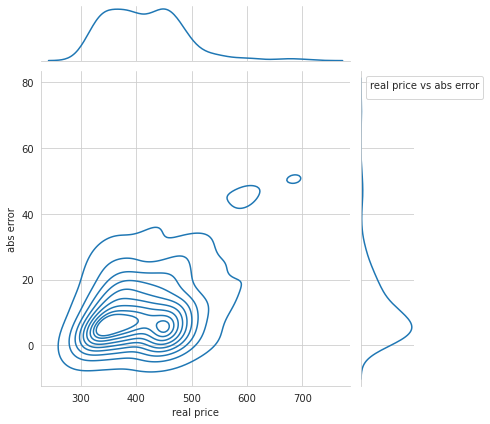

In [ ]:
h=sns.jointplot(x = test_y, y = np.abs(test_y-pred_test), kind ='kde', row="day")
plt.legend(title='real price vs abs error')
h.ax_joint.set_ylabel('abs error')
h.ax_joint.set_xlabel('real price')

No handles with labels found to put in legend.


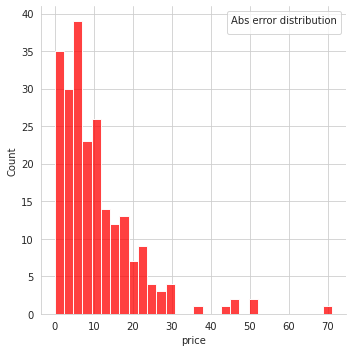

In [ ]:
sns.set_style('whitegrid')
h=sns.displot(np.abs(test_y-pred_test), kde = False, color ='red', bins = 30)
plt.legend(title='Abs error distribution')

### Explain predictions using shap

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20XGBoost.html

In [ ]:
explainer = shap.TreeExplainer(xgb_r)

shap_values = explainer.shap_values(train_X)

Visualize a single prediction

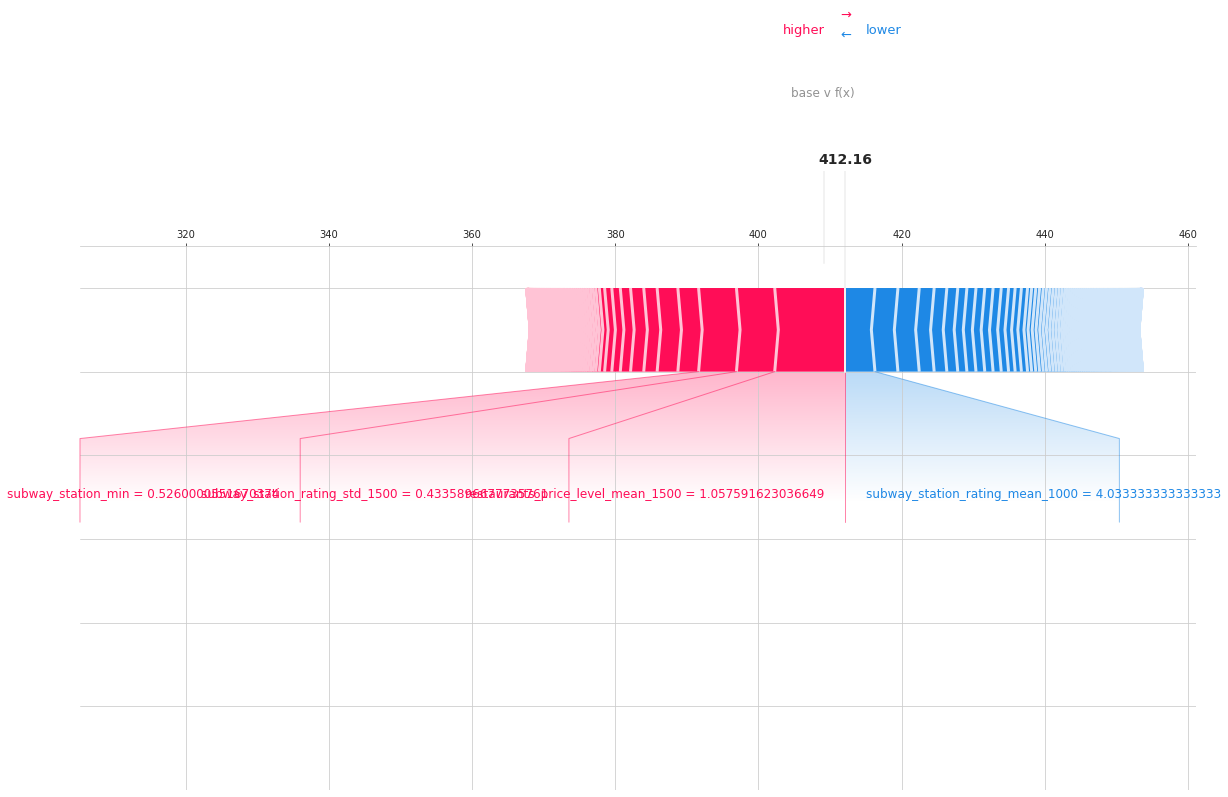

In [ ]:
g=shap.force_plot(explainer.expected_value, shap_values[1,:], train_X.iloc[1,:],show=False,matplotlib=True, figsize=(20, 10))

Bar chart of mean importance

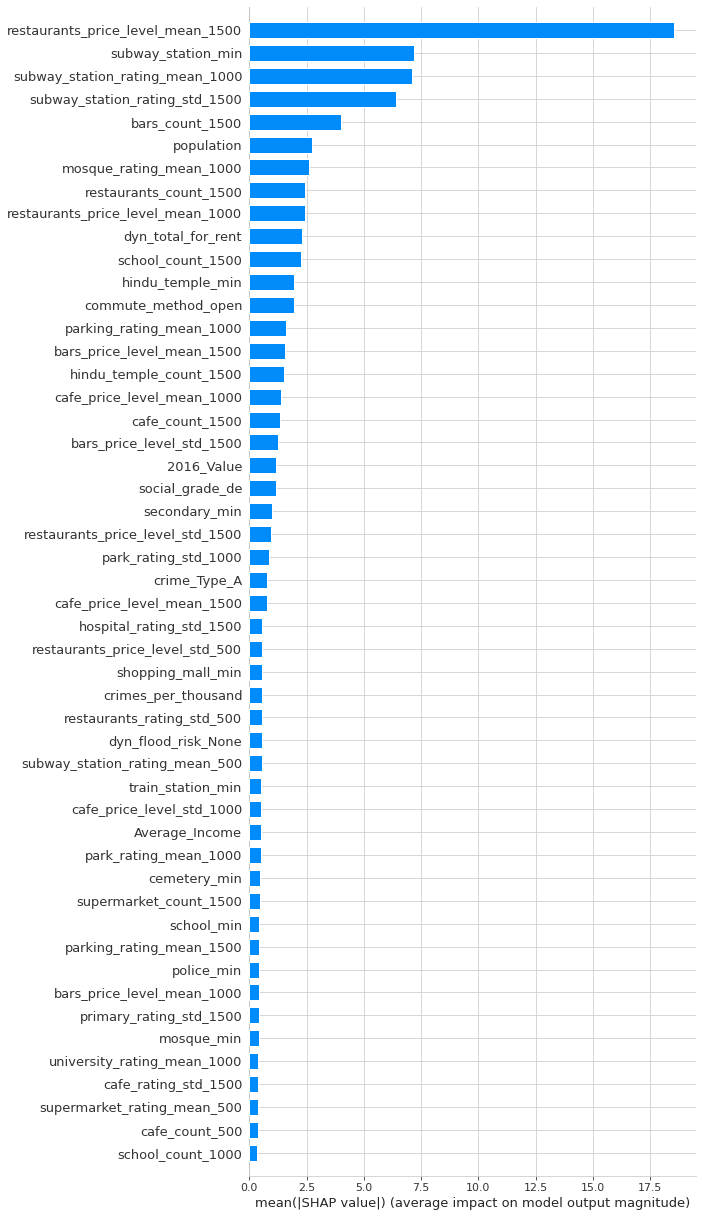

In [ ]:
shap.summary_plot(shap_values, train_X, plot_type="bar",max_display=50)

SHAP Summary Plot

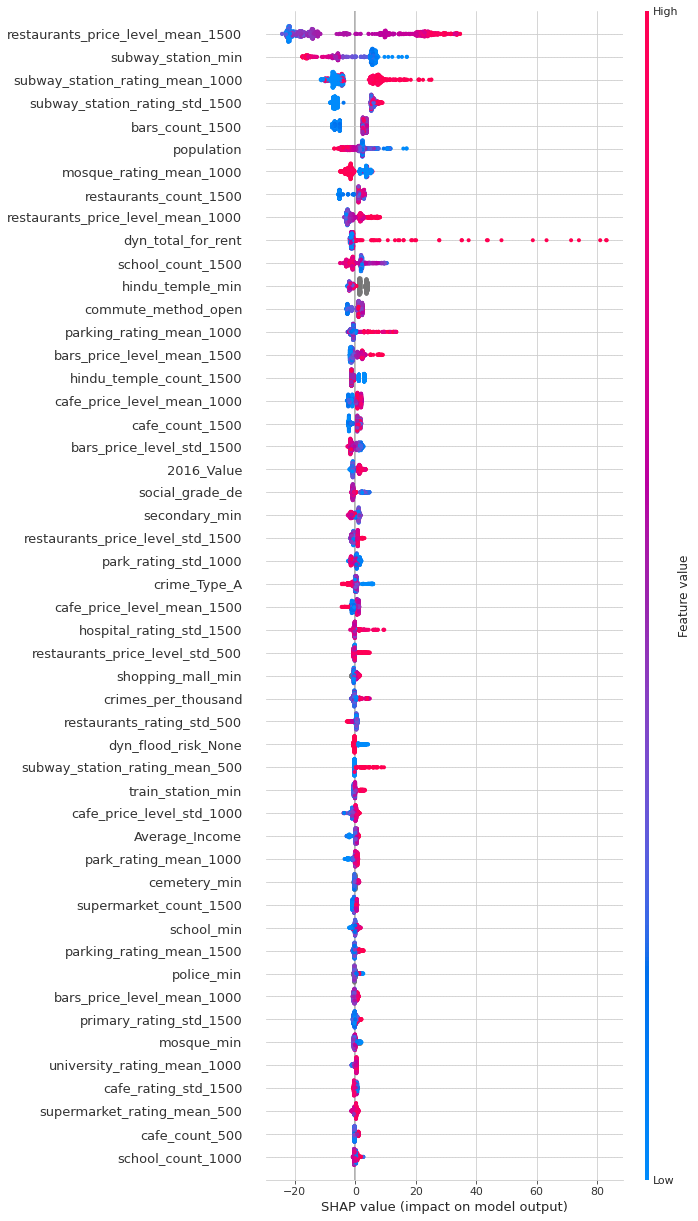

In [ ]:
shap.summary_plot(shap_values, train_X,max_display=50)